In [1]:


import pandas as pd
import numpy as np
import networkx as nx

In [2]:
wx = pd.read_excel(r'C:\Users\许高杰\Desktop\运动控制自动标定软件\平台责任.xlsx')#原始下载的文件识别不了，另存为.xlsx就可以了
wx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SrcDatabase-来源库  200 non-null    object 
 1   Title-题名         200 non-null    object 
 2   Author-作者        197 non-null    object 
 3   Organ-单位         200 non-null    object 
 4   Source-文献来源      200 non-null    object 
 5   Keyword-关键词      200 non-null    object 
 6   PubTime-发表时间     200 non-null    object 
 7   FirstDuty-第一责任人  197 non-null    object 
 8   Fund-基金          45 non-null     object 
 9   Year-年           199 non-null    float64
dtypes: float64(1), object(9)
memory usage: 15.8+ KB


In [3]:
wx.head()   #显示前5条数据

,SrcDatabase-来源库,Title-题名,Author-作者,Organ-单位,Source-文献来源,Keyword-关键词,PubTime-发表时间,FirstDuty-第一责任人,Fund-基金,Year-年
0,期刊,数据可视化信息误导现状及发展趋势研究,郝珊;,上海大学上海美术学院;,情报杂志,数据可视化;;信息误导;;批判性素养;;新闻传播;;数据新闻,2023-10-11 11:03,郝珊,国家留学基金资助(编号:CSC202006890038),NaN
1,期刊,数据新闻创新应用特点、问题及发展趋势,毕秋敏;,云南财经大学传媒与设计艺术学院;,传播与版权,数据新闻;;智能媒体;;移动化;;视频化;;应用化,2023-09-30,毕秋敏;,云南省专业学位研究生教学案例库（2022年）项目“《数据新闻学》教学案例库”成果,2023.0
2,期刊,新闻传播学视野下数据新闻的研究热点及趋势——基于中国知网（2012—2021年）的文献分析,尚媛媛;王雪蓉;,中国地质大学(武汉)艺术与传媒学院;,传媒论坛,数据新闻;;CiteSpace;;文献综述,2023-09-25,尚媛媛;,NaN,2023.0
3,期刊,交往合理性理论视域下数据新闻发展研究,徐海丽;,广州华商学院;,南宁师范大学学报(哲学社会科学版),数据新闻;;事实困境;;价值困境;;交往合理性,2023-09-25,徐海丽;,广州华商学院科研项目“后真相时代基于社交媒体大数据的研究”(2020HSDS12);; 国家...,2023.0
4,期刊,数据新闻的伦理风险及对策分析,陈檄;,南通大学经济与管理学院;,传播与版权,数据新闻;;新闻伦理;;伦理风险;;大数据,2023-09-15,陈檄;,江苏省教育厅基金项目“互联网时代数据新闻的伦理风险研究”（项目编号：2021SJA1588）成果,2023.0


In [4]:
#来源期刊统计
wx['Source-文献来源'].value_counts()[:10]  

新闻研究导刊    14
青年记者      10
新闻文化建设     9
西部广播电视     8
传媒         7
传媒论坛       7
视听         7
采写编        6
全媒体探索      5
科技传播       4
Name: Source-文献来源, dtype: int64

In [5]:
import re
keyword=wx['Keyword-关键词'].dropna(axis=0,how='all').tolist() #提取“关键词”这一列，去掉带空值的行，并转换为列表
new_list=[];
#使用re模块的split函数分割字符串，此操作不能对列表，只能一行行处理。多个分隔符用“|” 隔开.
for i in range(len(keyword)):
    new_list.append(list(filter(None, re.split(';;|;',keyword[i]) )))  #得到的new_list为二维数组，里面的每一行为一篇文献的关键词（已分隔）
keyword1=sum(new_list,[])  #转换为一维数组
pd.DataFrame(keyword1)[0].value_counts()[:10]  #统计关键词频数，显示前10

数据新闻     188
可视化       40
数据可视化     17
大数据       14
传播效果       6
新华网        6
网易数读       6
新闻生产       5
媒体融合       5
视觉修辞       5
Name: 0, dtype: int64

In [6]:
#获取前30高频数据,并转换为列表
keyword2=pd.DataFrame(keyword1)[0].value_counts()[:30].index.tolist()
keyword2

['数据新闻',
 '可视化',
 '数据可视化',
 '大数据',
 '传播效果',
 '新华网',
 '网易数读',
 '新闻生产',
 '媒体融合',
 '视觉修辞',
 '大数据时代',
 '叙事',
 '人才培养',
 '创新路径',
 '可视化叙事',
 '新闻叙事',
 '叙事策略',
 '新闻传播',
 '交互性',
 '传播策略',
 '新闻报道',
 '智媒时代',
 '交互',
 '人工智能',
 '健康传播',
 '新媒体',
 '突发公共卫生事件',
 '民生新闻',
 '可视化呈现',
 '创新']

In [7]:
#自定义共现矩阵，data为一维数组，document为二维数组，如前面的new_list
def occurence(data,document):
    empty1=[]
    empty2=[]
    empty3=[]
    for a in data:
        for b in data:
            count=0
            for x in document:
                if [a in i for i in x].count(True)>0 and [b in i for i in x].count(True)>0:
                    count+=1
            empty1.append(a)
            empty2.append(b)
            empty3.append(count)
    df=pd.DataFrame({'from':empty1,'to':empty2,'weight':empty3})
    G=nx.from_pandas_edgelist(df,'from','to','weight')
    return G,nx.to_pandas_adjacency(G,dtype=int) #返回两个参数，分别为图、连接矩阵

In [8]:
k=occurence(keyword2,new_list)
gk=k[0] #图
mk=k[1] #连接矩阵
mk

,数据新闻,可视化,数据可视化,大数据,传播效果,新华网,网易数读,新闻生产,媒体融合,视觉修辞,...,新闻报道,智媒时代,交互,人工智能,健康传播,新媒体,突发公共卫生事件,民生新闻,可视化呈现,创新
数据新闻,190,68,15,17,6,6,7,5,5,4,...,4,3,14,3,3,5,3,3,3,10
可视化,68,73,17,10,3,4,2,1,2,2,...,1,0,10,1,2,3,1,1,3,2
数据可视化,15,17,17,1,2,2,1,1,0,1,...,1,0,1,0,1,0,0,0,0,0
大数据,17,10,1,20,0,1,0,1,0,0,...,1,0,1,0,0,0,0,1,0,3
传播效果,6,3,2,0,6,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
新华网,6,4,2,1,0,6,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
网易数读,7,2,1,0,1,0,7,0,0,0,...,0,0,0,0,1,0,0,0,0,0
新闻生产,5,1,1,1,0,0,0,6,1,0,...,0,0,0,0,0,0,0,0,0,1
媒体融合,5,2,0,0,0,0,0,1,5,0,...,0,0,2,0,0,0,0,0,0,0
视觉修辞,4,2,1,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#将连接矩阵保存为EXCEL文件
mk.to_excel(file_path, index=False) 

In [10]:
# 加权网络阈值化
mk2=mk
#l=len(mk2)
#i=0
#对角线设为0
for i in range( len(mk2) ):
    mk2.iat[i,i]=0
#阈值化，小于3的设为0
mk2[mk2 < 3]=0
mk2

,数据新闻,可视化,数据可视化,大数据,传播效果,新华网,网易数读,新闻生产,媒体融合,视觉修辞,...,新闻报道,智媒时代,交互,人工智能,健康传播,新媒体,突发公共卫生事件,民生新闻,可视化呈现,创新
数据新闻,0,68,15,17,6,6,7,5,5,4,...,4,3,14,3,3,5,3,3,3,10
可视化,68,0,17,10,3,4,0,0,0,0,...,0,0,10,0,0,3,0,0,3,0
数据可视化,15,17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
大数据,17,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
传播效果,6,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
新华网,6,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
网易数读,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
新闻生产,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
媒体融合,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
视觉修辞,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


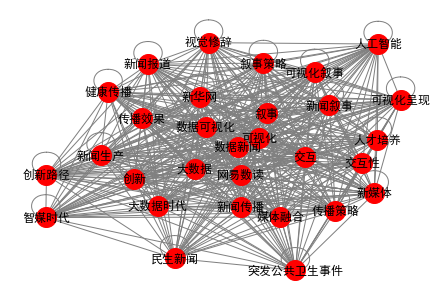

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei'  # 设置字体为SimHei,解决中文乱码
pos=nx.spring_layout(gk)
nx.draw(gk,with_labels=True,
        node_size=400,node_color='r', 
        edge_color='gray',width=1, #边颜色和粗细
        pos=pos)

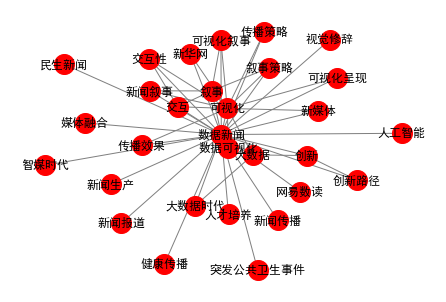

In [14]:
gk2=nx.from_pandas_adjacency(mk2)  #将pandas数据mk2转换为图数据gk2
pos=nx.spring_layout(gk2)
nx.draw(gk2,with_labels=True,
        node_size=400,node_color='r', 
        edge_color='gray',width=1, #边颜色和粗细
        pos=pos)

In [37]:
print(gk2['新媒体'])

{'数据新闻': {'weight': 5}, '可视化': {'weight': 3}}


In [38]:
nx.degree(gk2)

DegreeView({'数据新闻': 29, '可视化': 14, '数据可视化': 2, '大数据': 4, '传播效果': 2, '新华网': 2, '网易数读': 1, '新闻生产': 1, '媒体融合': 1, '视觉修辞': 1, '大数据时代': 2, '叙事': 6, '人才培养': 1, '创新路径': 2, '可视化叙事': 3, '新闻叙事': 3, '叙事策略': 3, '新闻传播': 1, '交互性': 3, '传播策略': 2, '新闻报道': 1, '智媒时代': 1, '交互': 4, '人工智能': 1, '健康传播': 1, '新媒体': 2, '突发公共卫生事件': 1, '民生新闻': 1, '可视化呈现': 2, '创新': 3})

In [39]:
nx.degree(gk2,'新媒体')


2

In [59]:
#平均度
sum(dict(gk2.degree).values())/len(gk2)

3.3333333333333335

In [12]:
#网络密度
nx.density(gk2)

0.11494252873563218

In [40]:
#所有节点聚类系数
nx.clustering(gk2)

{'数据新闻': 0.05172413793103448,
 '可视化': 0.1978021978021978,
 '数据可视化': 1.0,
 '大数据': 0.5,
 '传播效果': 1.0,
 '新华网': 1.0,
 '网易数读': 0,
 '新闻生产': 0,
 '媒体融合': 0,
 '视觉修辞': 0,
 '大数据时代': 1.0,
 '叙事': 0.6,
 '人才培养': 0,
 '创新路径': 1.0,
 '可视化叙事': 1.0,
 '新闻叙事': 1.0,
 '叙事策略': 1.0,
 '新闻传播': 0,
 '交互性': 1.0,
 '传播策略': 1.0,
 '新闻报道': 0,
 '智媒时代': 0,
 '交互': 0.8333333333333334,
 '人工智能': 0,
 '健康传播': 0,
 '新媒体': 1.0,
 '突发公共卫生事件': 0,
 '民生新闻': 0,
 '可视化呈现': 1.0,
 '创新': 0.6666666666666666}

In [56]:
#整个网络评价聚类系数
nx.average_clustering(gk2)

0.49498421119110775

In [47]:
#两个节点间距离

nx.shortest_path_length(gk2,'新闻生产','网易数读')


2

In [60]:
#平均路径长度
nx.average_shortest_path_length(gk2)

1.8850574712643677

In [22]:
#某个节点离心率
nx.eccentricity(gk2,'可视化')  

2

In [23]:
#所有节点离心率
nx.eccentricity(gk2)

{'数据新闻': 1,
 '可视化': 2,
 '数据可视化': 2,
 '大数据': 2,
 '传播效果': 2,
 '新华网': 2,
 '网易数读': 2,
 '新闻生产': 2,
 '媒体融合': 2,
 '视觉修辞': 2,
 '大数据时代': 2,
 '叙事': 2,
 '人才培养': 2,
 '创新路径': 2,
 '可视化叙事': 2,
 '新闻叙事': 2,
 '叙事策略': 2,
 '新闻传播': 2,
 '交互性': 2,
 '传播策略': 2,
 '新闻报道': 2,
 '智媒时代': 2,
 '交互': 2,
 '人工智能': 2,
 '健康传播': 2,
 '新媒体': 2,
 '突发公共卫生事件': 2,
 '民生新闻': 2,
 '可视化呈现': 2,
 '创新': 2}

In [25]:
#网络直径
nx.diameter(gk2)

2

In [68]:
#节点度中心性
nx.degree_centrality(gk2)

{'数据新闻': 1.0,
 '可视化': 0.48275862068965514,
 '数据可视化': 0.06896551724137931,
 '大数据': 0.13793103448275862,
 '传播效果': 0.06896551724137931,
 '新华网': 0.06896551724137931,
 '网易数读': 0.034482758620689655,
 '新闻生产': 0.034482758620689655,
 '媒体融合': 0.034482758620689655,
 '视觉修辞': 0.034482758620689655,
 '大数据时代': 0.06896551724137931,
 '叙事': 0.20689655172413793,
 '人才培养': 0.034482758620689655,
 '创新路径': 0.06896551724137931,
 '可视化叙事': 0.10344827586206896,
 '新闻叙事': 0.10344827586206896,
 '叙事策略': 0.10344827586206896,
 '新闻传播': 0.034482758620689655,
 '交互性': 0.10344827586206896,
 '传播策略': 0.06896551724137931,
 '新闻报道': 0.034482758620689655,
 '智媒时代': 0.034482758620689655,
 '交互': 0.13793103448275862,
 '人工智能': 0.034482758620689655,
 '健康传播': 0.034482758620689655,
 '新媒体': 0.06896551724137931,
 '突发公共卫生事件': 0.034482758620689655,
 '民生新闻': 0.034482758620689655,
 '可视化呈现': 0.06896551724137931,
 '创新': 0.10344827586206896}

In [70]:
#接近中心性
nx.closeness_centrality(gk2)

{'数据新闻': 1.0,
 '可视化': 0.6590909090909091,
 '数据可视化': 0.5178571428571429,
 '大数据': 0.5370370370370371,
 '传播效果': 0.5178571428571429,
 '新华网': 0.5178571428571429,
 '网易数读': 0.5087719298245614,
 '新闻生产': 0.5087719298245614,
 '媒体融合': 0.5087719298245614,
 '视觉修辞': 0.5087719298245614,
 '大数据时代': 0.5178571428571429,
 '叙事': 0.5576923076923077,
 '人才培养': 0.5087719298245614,
 '创新路径': 0.5178571428571429,
 '可视化叙事': 0.5272727272727272,
 '新闻叙事': 0.5272727272727272,
 '叙事策略': 0.5272727272727272,
 '新闻传播': 0.5087719298245614,
 '交互性': 0.5272727272727272,
 '传播策略': 0.5178571428571429,
 '新闻报道': 0.5087719298245614,
 '智媒时代': 0.5087719298245614,
 '交互': 0.5370370370370371,
 '人工智能': 0.5087719298245614,
 '健康传播': 0.5087719298245614,
 '新媒体': 0.5178571428571429,
 '突发公共卫生事件': 0.5087719298245614,
 '民生新闻': 0.5087719298245614,
 '可视化呈现': 0.5178571428571429,
 '创新': 0.5272727272727272}

In [71]:
#中介中心性
nx.betweenness_centrality(gk2)

{'数据新闻': 0.8505747126436782,
 '可视化': 0.0870279146141215,
 '数据可视化': 0.0,
 '大数据': 0.003694581280788177,
 '传播效果': 0.0,
 '新华网': 0.0,
 '网易数读': 0.0,
 '新闻生产': 0.0,
 '媒体融合': 0.0,
 '视觉修辞': 0.0,
 '大数据时代': 0.0,
 '叙事': 0.0049261083743842365,
 '人才培养': 0.0,
 '创新路径': 0.0,
 '可视化叙事': 0.0,
 '新闻叙事': 0.0,
 '叙事策略': 0.0,
 '新闻传播': 0.0,
 '交互性': 0.0,
 '传播策略': 0.0,
 '新闻报道': 0.0,
 '智媒时代': 0.0,
 '交互': 0.0008210180623973727,
 '人工智能': 0.0,
 '健康传播': 0.0,
 '新媒体': 0.0,
 '突发公共卫生事件': 0.0,
 '民生新闻': 0.0,
 '可视化呈现': 0.0,
 '创新': 0.0012315270935960591}

C:\Users\dan\AppData\Local\Temp\ipykernel_1168\4070684547.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  h=sch.linkage(mk2,method='ward')


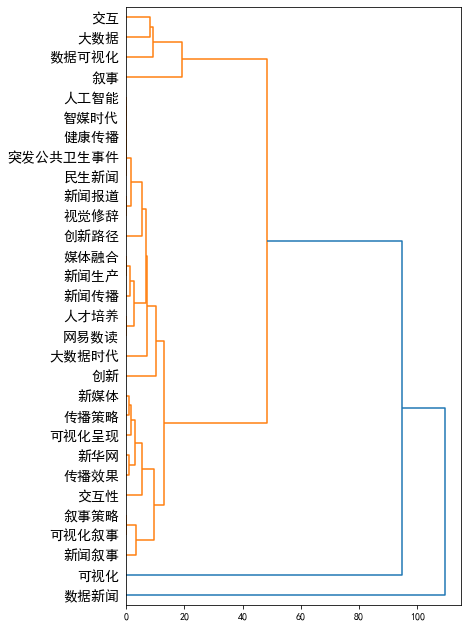

In [86]:
#层次聚类
import scipy.cluster.hierarchy as sch

fig = plt.figure(figsize=(6,11))
h=sch.linkage(mk2,method='ward')    #聚类方法为ward
sch.dendrogram(h,labels=mk2.index,  #标签为mk2的索引
               orientation='right', #方向为朝右
               leaf_font_size=14)   #字号为14号
plt.show()